In [4]:
import numpy as np
import time
import multiprocessing as mpr
import h5py
import os
import configparser
import logging
from mpmath import mp, mpc, sqrt, exp, besselj, quad,log, atan,atanh


mp.dps = 50  # set precision to 50 decimal places (arbitrary precision)
eps = 1e-3  # relative accuracy tolerance


def psi(x, rs):
    if x == 0:
        return 0
    elif x < 1:
        return rs/2 * ((log(x/2))**2 - atanh(sqrt(1 - x**2))**2)
    else:
        return rs/2 * ((log(x/2))**2 +  atan(sqrt(x**2 - 1))**2)
    

def func(x, w, y,rs):
    # x: real integration variable (mpf)
    # w, y, amp, core, p: mpc or mpf
    sqrt2x = sqrt(2 * x)
    arg_bessel = w * y * sqrt2x
    bessel_val = besselj(0, arg_bessel)
    psi_val = psi(sqrt2x, rs)
    return bessel_val * exp(-1j * w * psi_val)

def func2(x, w, y, rs):
    return func(x, w, y, rs) * exp(1j * w * x)

def dfunc(x, w, y, rs):
    sqrt2x = sqrt(2 * x)
    psi_val = psi(sqrt2x, rs)
    J1 = besselj(1, w * y * sqrt2x)
    prefactor = -w * y / sqrt2x
    return prefactor * J1 * exp(-1j * w * psi_val) - (1j * w / (2 * x)) * func(x, w, y,rs)

def ddfunc(x, w, y,rs):
    sqrt2x = sqrt(2 * x)
    psi_val = psi(sqrt2x, rs)
    #denom = (sqrt2x**2 + core**2)**(1 - p/2)
    #dpsi = amp * p * sqrt2x / denom
    
    # derivative squared term:
    #d2psi = amp * p * (1 - p / 2) * (2 * x)**(-0.5) * (1 - 2 * x / (2 * x + core**2)) / (2 * x + core**2)**(1 - p/2)
    
    term1 = (w * y) / (2 * x * sqrt2x) * (2 + 1j * w) * besselj(1, w * y * sqrt2x) * exp(-1j * w * psi_val)
    term2 = -1 / (2 * x) * (w**2 * y**2 - 1j * w / x) * func(x, w, y, rs)
    term3 = -1j * w / (2 * x) * dfunc(x, w, y,rs)
    return term1 + term2 + term3



def NFW(w, y, rs):
    a = 0.00001

    if w < 1 :
        b = 100 / w
    elif 1 < w < 500:
        b = 1000/w 
    else: b = 10000/w   
    #zzp = mpc(-1)
    
    
    # mpmath.quad with complex integrand
    zz = quad(lambda x: func2(x, w, y,rs), [a, b], error=True, maxdegree=10)
    zz_val = zz[0]  # integral value
    
    # Add tail correction terms (at b)
    tail = (-func(b, w, y, rs) / (1j * w) * exp(1j * w * b)
            - dfunc(b, w, y, rs) / (w**2) * exp(1j * w * b)
            + ddfunc(b, w, y, rs) / (1j * w**3) * exp(1j * w * b))
    
    zz_val += tail
        
    return -1j * w * exp(0.5 * 1j * w * y**2) * zz_val

In [40]:
impact = np.linspace(0.01,1,10)
results2 = []
for y in impact:
    F = NFW(w= 2.0, y=y, rs= 0.01)
    print(F)
    Freal = F.real
    Fimag = F.imag
    Fabs = np.abs(F)
    results1.append(Fabs)



(1.0043425658608309959999354587768412647027689789332 - 0.0018186091076511983191890090101064535599710904337645j)
(1.0039066379602078843983602837510475341152271545149 - 0.0023316228413629842201079470611032303849659435339353j)
(1.0037234351761370536257330088304529592104597362324 - 0.002545762641751721149022145255198399837690556375203j)
(1.0035318062169041315496590196739280723748018792598 - 0.0027837151416100713125891410034447502626262876543462j)
(1.0033385842933134913315384755744735969040885034333 - 0.0030393600938821393342359505027579020888315499612822j)
(1.0031446570662842578617975492012532511731108733399 - 0.0033011424301188360031566221350897260701461615020425j)
(1.002936714418020641825934213220224177345446040614 - 0.0035706481167933222580984253530545034576621126348317j)
(1.0026965025507743289441957836081518500616814840426 - 0.0038679484607374975295036971667139443593349911812655j)
(1.0024160387093533565200553826914562830689833859074 - 0.0042263611061653216479360370584792751326735678503

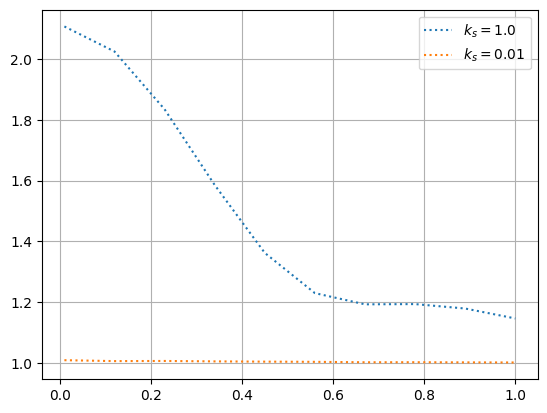

In [22]:
import matplotlib.pyplot as plt
plt.plot(impact, results, ls = "dotted", label= "$k_s = 1.0$")
plt.plot(impact, results1, ls = "dotted", label= "$k_s = 0.01$")
plt.legend()
plt.grid()

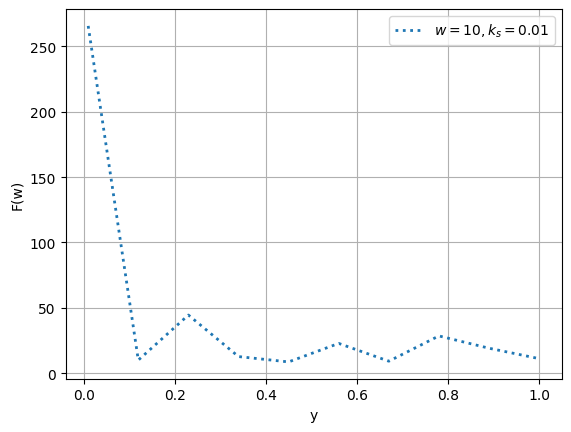

In [32]:
plt.plot(impact, results1[10:], ls = "dotted", label= "$w= 10,k_s = 0.01$",lw= 2)
#plt.plot(impact, results2, ls = "dotted", label= "$w= 1,k_s = 0.01$",lw= 2)
plt.xlabel("y")
plt.ylabel("F(w)")
plt.legend()
plt.grid()

